Import of packages

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, AveragePooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

Function for loading the labeled dataset in correct order

In [85]:
def load_data(dataset_dir, labes_dir):
    # Load the labels
    labels_df = pd.read_csv(labes_dir)

    # Sort labels by ID to ensure the order matches the .npy file order
    labels_df = labels_df.sort_values('ID').reset_index(drop=True)

    # Initialize lists to collect data and labels
    data_list = []
    labels_list = []

    # Loop over IDs in order
    for idx, row in labels_df.iterrows():
        file_path = os.path.join(dataset_dir, f"{row['ID']}.npy")
        data = np.load(file_path)
        data_list.append(data)
        labels_list.append(row['target'])

    # Convert to numpy arrays
    dataset = np.array(data_list)
    dataset_labels = np.array(labels_list)
    
    return dataset, dataset_labels

Loading the dataset

In [86]:
TRAIN_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Train/'
TEST_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Test/'
LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/label_train.csv'
EMPTY_LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/test_format.csv'

dataset, dataset_labels = load_data(TRAIN_DIR, LABEL_PATH)
submition_data, submition_data_labels = load_data(TEST_DIR, EMPTY_LABEL_PATH)

print(f"Data shape: {dataset.shape}")
print(f"Labels shape: {dataset_labels.shape}")
print(f"Kaggle data shape: {submition_data.shape}")
print(f"Kaggle labels shape: {submition_data_labels.shape}")

nodeB_0 = dataset[dataset_labels == 0]
nodeB_1 = dataset[dataset_labels == 1]
nodeB_2 = dataset[dataset_labels == 2]
print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")

Data shape: (1491, 72, 48)
Labels shape: (1491,)
Kaggle data shape: (120, 72, 48)
Kaggle labels shape: (120,)
Num of nodeB_0: 1209 
Num of nodeB_1: 141 
Num of nodeB_2: 141 



Visualise one train LTE frame sample

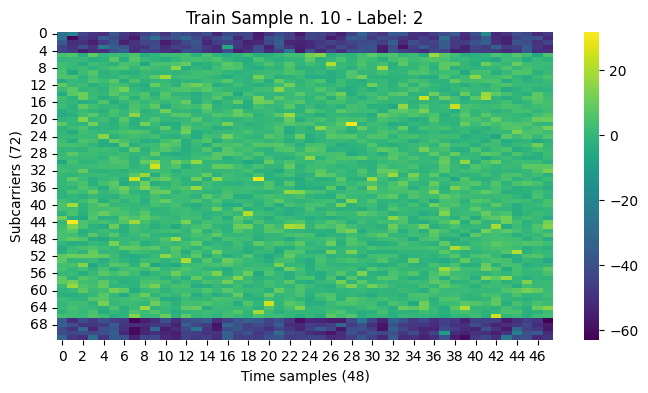

In [87]:
i = 10
plt.figure(figsize=(8, 4))
sns.heatmap(dataset[i], cmap='viridis')
plt.title(f"Train Sample n. {i} - Label: {int(dataset_labels[i])}")
plt.xlabel("Time samples (48)")
plt.ylabel("Subcarriers (72)")
plt.show()

In [88]:
x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.1, random_state=42)

x_eval = submition_data

x_train_aug, x_val, y_train_aug, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.12, 
    stratify=y_train, 
    random_state=42
)

print("x_test shape:", x_test.shape)
print("x_train before augmentation shape:", x_train_aug.shape)
print("x_val validation shape:", x_val.shape)

x_test shape: (150, 72, 48)
x_train before augmentation shape: (1180, 72, 48)
x_val validation shape: (161, 72, 48)


In [89]:
def apply_frequency_selective_fading_db(samples, min_db=-5, max_db=5):
    N, H, W = samples.shape
    fading_db = np.random.uniform(min_db, max_db, size=(N, H, 1))
    return samples + fading_db

In [90]:
def augment_data(dataset, labels, multiplier = 2, std1 = 3, std2 = 5):
    nodeB_0 = dataset[labels == 0]
    nodeB_1 = dataset[labels == 1]
    nodeB_2 = dataset[labels == 2]

    #plt.hist(dataset.flatten(order='C'), bins='auto')

    print("Training")
    print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")
    
    for k in range(multiplier):
        nodeB_0 = nodeB_0 + np.random.normal(0, std1, nodeB_0.shape)
        dataset = np.append(dataset, nodeB_0, 0)
        labels = np.append(labels, np.zeros(nodeB_0.shape[0]))
        
    N_nodeB_0 = np.count_nonzero(labels == 0)

    print("Enlargin NB1 by: ", N_nodeB_0//nodeB_1.shape[0])
    for k in range(N_nodeB_0//nodeB_1.shape[0]):
        nodeB_1 = nodeB_1 + np.random.normal(0, k//std2, nodeB_1.shape)
        dataset = np.append(dataset, nodeB_1, 0)
        labels = np.append(labels, np.ones(nodeB_1.shape[0]))

    print("Enlargin NB2 by: ", N_nodeB_0//nodeB_2.shape[0])
    for k in range(N_nodeB_0//nodeB_2.shape[0]):
        nodeB_2 = nodeB_2 + np.random.normal(0, k//std2, nodeB_2.shape)
        dataset = np.append(dataset, nodeB_2, 0)
        labels = np.append(labels, 2 * np.ones(nodeB_2.shape[0]))    
        
    print("Enlarged dataset")
    print("Num of nodeB_0:", np.count_nonzero(labels == 0), "\nNum of nodeB_1:", np.count_nonzero(labels == 1), "\nNum of nodeB_2:", np.count_nonzero(labels == 2), "\n")

    print("Final size of dataset: ", dataset.shape)
    print("Final size of labels: ", labels.shape)
    return dataset, labels

In [91]:
x_train_aug, y_train_aug = augment_data(x_train_aug, y_train_aug, 1, 3, 3)
#x_test, y_test = augment_data(x_test, y_test, 1, 1, 3)

""" nodeB_0 = x_train_aug[y_train_aug == 0]
x_train_aug = np.append(x_train_aug, apply_frequency_selective_fading_db(nodeB_0, -3, 3), 0)
y_train_aug = np.append(y_train_aug, 0 * np.ones(nodeB_0.shape[0]))    

nodeB_1 = x_train_aug[y_train_aug == 1]
x_train_aug = np.append(x_train_aug, apply_frequency_selective_fading_db(nodeB_1, -3, 3), 0)
y_train_aug = np.append(y_train_aug, 0 * np.ones(nodeB_1.shape[0]))   

nodeB_2 = x_train_aug[y_train_aug == 2]
x_train_aug = np.append(x_train_aug, apply_frequency_selective_fading_db(nodeB_2, -3, 3), 0)
y_train_aug = np.append(y_train_aug, 0 * np.ones(nodeB_2.shape[0]))  """  

print("Final size of dataset: ", x_train_aug.shape)
print("Final size of labels: ", y_train_aug.shape)

Training
Num of nodeB_0: 957 
Num of nodeB_1: 108 
Num of nodeB_2: 115 

Enlargin NB1 by:  17
Enlargin NB2 by:  16
Enlarged dataset
Num of nodeB_0: 1914 
Num of nodeB_1: 1944 
Num of nodeB_2: 1955 

Final size of dataset:  (5813, 72, 48)
Final size of labels:  (5813,)
Final size of dataset:  (5813, 72, 48)
Final size of labels:  (5813,)


In [92]:
# normalization of training data
x_train_mean = np.mean(x_train_aug)
x_train_deviation = np.std(x_train_aug)
x_train_normalized = (x_train_aug - x_train_mean) / x_train_deviation

# normalization of validation data
x_val_mean = np.mean(x_val)
x_val_deviation = np.std(x_val)
x_val_normalized = (x_val - x_val_mean) / x_val_deviation

# normalization of test data
x_test_mean = np.mean(x_test)
x_test_deviation = np.std(x_test)
x_test_normalized = (x_test - x_test_mean) / x_test_deviation

# normalization of submition data
x_eval_mean = np.mean(x_eval)
x_eval_deviation = np.std(x_eval)
x_eval_normalized = (x_eval - x_eval_mean) / x_eval_deviation

x_train_normalized = x_train_normalized.reshape(-1, 72, 48, 1)
x_val_normalized = x_val_normalized.reshape(-1, 72, 48, 1)
x_test_normalized = x_test_normalized.reshape(-1, 72, 48, 1)
x_eval_normalized = x_eval_normalized.reshape(-1, 72, 48, 1)

y_train_encoded = to_categorical(y_train_aug, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [93]:
model = Sequential()

model.add(Input(shape=(72, 48, 1)))

model.add(Conv2D(64, kernel_size=(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(64, activation='relu')) #128
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 68, 44, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 34, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │       327,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,051 (1.34 MB)

 Trainable params: 350,051 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history = model.fit(
    x_train_normalized, 
    y_train_encoded, 
    epochs=50, 
    batch_size=20, 
    validation_data=(x_val_normalized, y_val_encoded),
    callbacks=[early_stopping]
)

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5831 - loss: 0.7995 - val_accuracy: 0.9876 - val_loss: 0.0487
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9306 - loss: 0.1968 - val_accuracy: 0.9876 - val_loss: 0.0440
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9639 - loss: 0.1102 - val_accuracy: 0.9876 - val_loss: 0.0287
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9771 - loss: 0.0664 - val_accuracy: 0.9876 - val_loss: 0.0424
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9906 - loss: 0.0336 - val_accuracy: 0.9876 - val_loss: 0.0254
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9921 - loss: 0.0207 - val_accuracy: 0.9938 - val_loss: 0.0068
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9974 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9932 - loss: 0.0241 - val_accu

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.7016e-04
Test loss: 0.001078169560059905
Test accuracy: 100.0 %
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


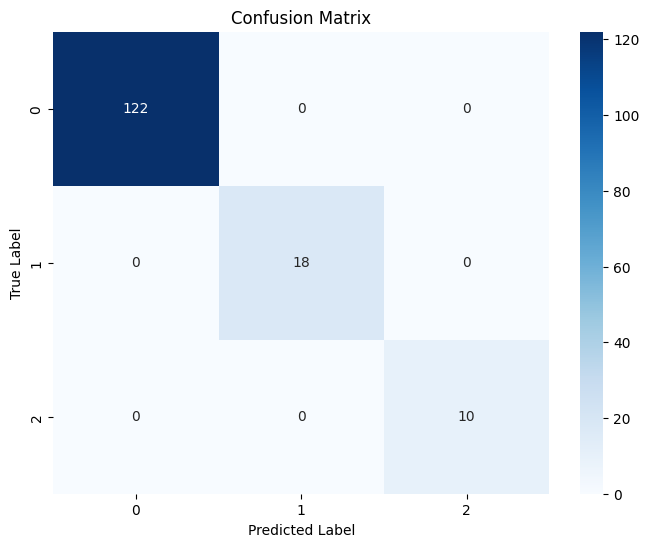

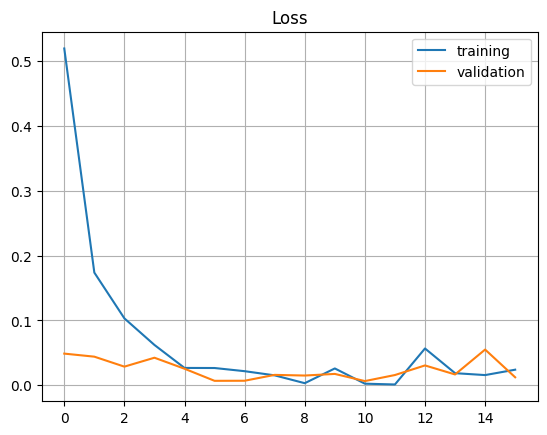

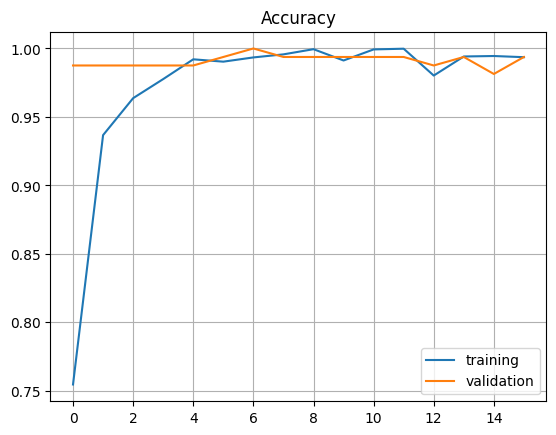

In [95]:
score = model.evaluate(x_test_normalized, y_test_encoded, verbose=1)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

y_pred_probs = model.predict(x_test_normalized)  # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test_encoded, axis=1)  # True labels

conf_matrix = confusion_matrix(y_true, y_pred_classes) # Compute confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid('both')
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.grid('both')

In [96]:
y_pred = model.predict(x_eval_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

import csv
with open('label_test_MT_v0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'target'])
    for i, value in enumerate(y_pred_classes):
        writer.writerow([i, value])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[1 0 1 2 0 0 2 0 2 0 1 1 1 0 1 2 0 2 2 2 0 0 2 1 0 0 2 1 1 1 2 0 2 2 2 0 2
 0 0 0 1 2 1 0 1 2 1 0 2 1 1 0 2 0 0 1 0 1 2 0 2 1 1 2 1 1 2 1 0 2 1 1 2 2
 2 1 1 2 2 2 0 1 2 2 0 2 0 1 0 2 2 1 2 0 2 0 0 2 0 0 0 0 2 1 2 2 1 0 1 2 2
 0 1 1 0 1 2 0 0 1]
